Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.3620 - val_loss: 0.2981
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.2944 - val_loss: 0.2933
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2897 - val_loss: 0.2895
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2874 - val_loss: 0.2871
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2836 - val_loss: 0.2853
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.2825 - val_loss: 0.2846
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2819 - val_loss: 0.2836
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2809 - val_loss: 0.2829
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2804 - val_loss: 0.2832
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2793 - val_loss: 0.2822
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.2795 - val_loss: 0.2817
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/ste

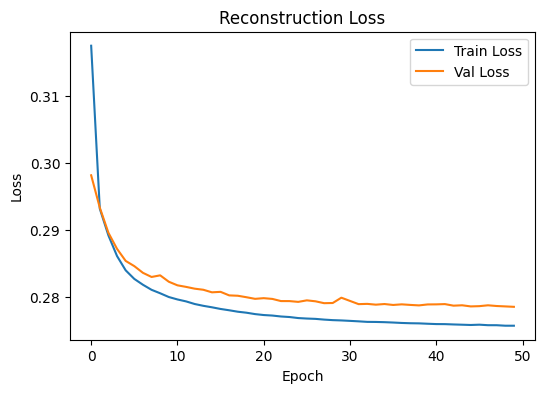

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


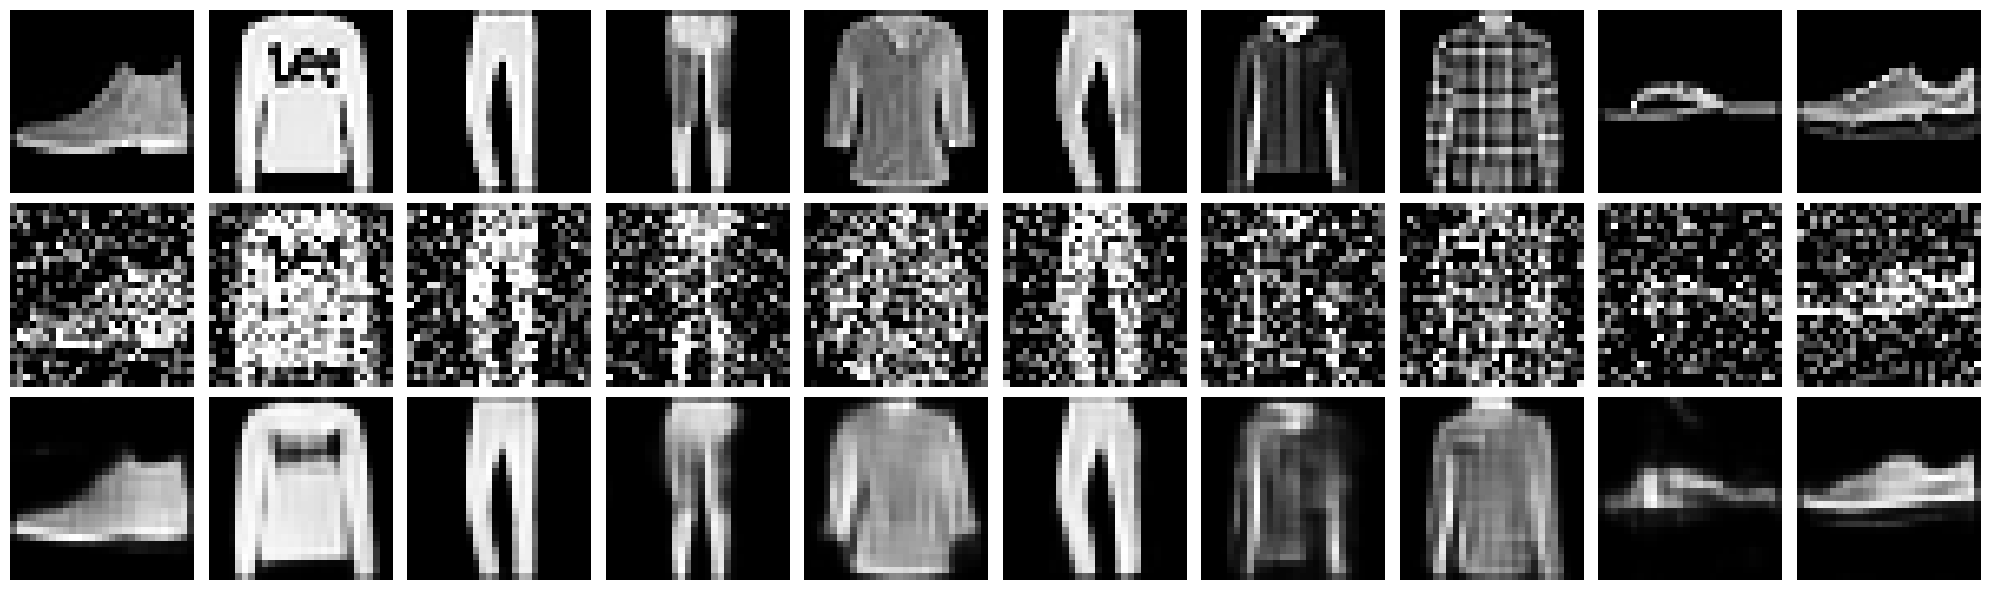

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


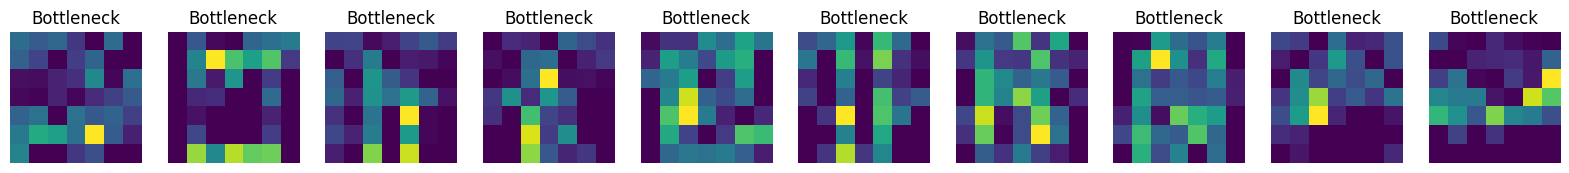

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


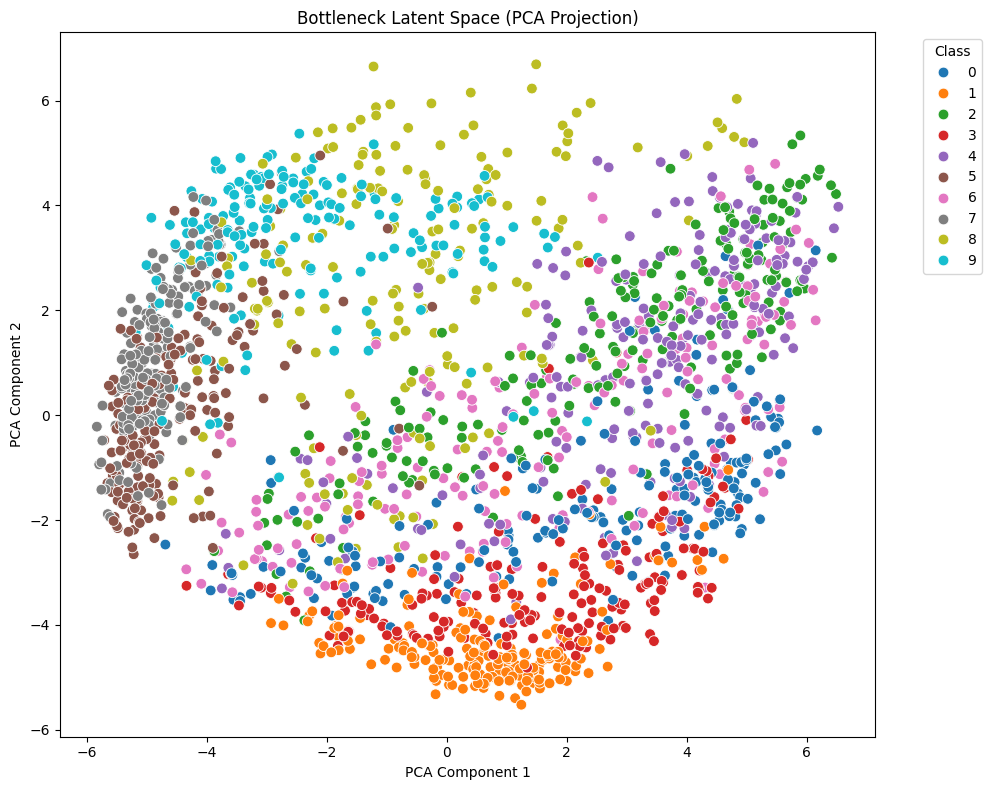

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA
import seaborn as sns

# Load and normalize Fashion MNIST data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Add noise to input data
noise_factor = 0.4
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Build the Convolutional Autoencoder
input_img = Input(shape=(28, 28, 1))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='bottleneck')(x)

# Decoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks=[early_stop]
)

# Plot training & validation loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict reconstructed images
decoded_imgs = autoencoder.predict(x_test_noisy)

# Visualize Original → Noisy → Reconstructed
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # Original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    if i == 0:
        ax.set_ylabel("Original", size=14)
    plt.axis('off')

    # Noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    if i == 0:
        ax.set_ylabel("Noisy", size=14)
    plt.axis('off')

    # Reconstructed
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    if i == 0:
        ax.set_ylabel("Denoised", size=14)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Bottleneck visualization (first channel)
bottleneck_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("bottleneck").output)
bottleneck_output = bottleneck_model.predict(x_test_noisy[:n])

plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(bottleneck_output[i].reshape(7, 7, 64)[:, :, 0], cmap='viridis')
    plt.title("Bottleneck")
    plt.axis('off')
plt.show()

# PCA Scatter Plot of Bottleneck Space
n_samples = 2000
x_subset = x_test_noisy[:n_samples]
y_subset = y_test[:n_samples]
bottleneck_features = bottleneck_model.predict(x_subset)
bottleneck_flat = bottleneck_features.reshape((n_samples, -1))

# PCA
pca = PCA(n_components=2)
bottleneck_2d = pca.fit_transform(bottleneck_flat)

# Scatter Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=bottleneck_2d[:, 0], y=bottleneck_2d[:, 1], hue=y_subset, palette='tab10', s=60)
plt.title("Bottleneck Latent Space (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
